In [1]:
# imports
import collections
import math
import heapq
import numpy as np
import itertools as it
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite
from collections import deque
from itertools import cycle


# Initialize

[1, 2, 3, 4, 5, 6]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


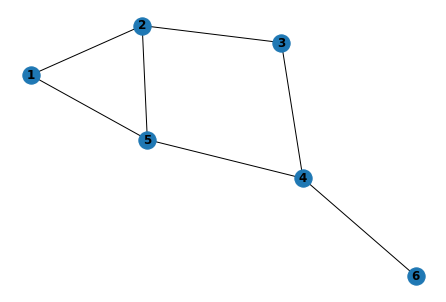

In [2]:
# set up demo graph
n = 6
_noderange = range(1,n+1)
G_A = nx.Graph()
Ef_A = nx.Graph()
P_A = nx.complete_graph(_noderange)

#
G_A.add_nodes_from(_noderange)
Ef_A.add_nodes_from(_noderange)
print(G_A.nodes)
G_A.add_edges_from(((4,5),(3,2),(4,3),(5,2),(6,4),(1,5),(1,2)))



nx.draw(G_A,with_labels=True,font_weight='bold')
#e1 = (5,4)
#e2 = (4,5)
#f1 = e1 in P_A.edges()
#f2 = e2 in P_A.edges()
#random = nx.erdos_renyi_graph(n,0.07)
#G_A.add_nodes_from(( node + 1 for node in random.nodes()))
#G_A.add_edges_from(( (edge[0]+1,edge[1]+1) for edge in random.edges()))

#print(G_A.nodes)
#print(G_A.edges)

#P_A.remove_edge(*e)
#f1 = e in P_A.edges()
#print(f1)

#display



# Algorithm 1: DegreeDiffElim

In [3]:
def DegreeDiffElim(G_A,P_A,kA):
    edges = list(P_A.edges())
    for e in edges:
        if abs(G_A.degree(e[0]) - G_A.degree(e[1])) > kA:
            P_A.remove_edge(*e)
    return P_A

# Algorithm 2: FixedDegElim

In [4]:
def FixedDegElim(G_A,P_A,Ef_A):
    edges = list(P_A.edges())
    for e in edges:
        if Ef_A.degree(e[0]) > G_A.degree(e[1]):
            P_A.remove_edge(*e)
    return P_A

# Algorithm 3: Helper Functions

In [5]:
def print_independence(v,i,j,G_A):
    edge,Ni,Nj = pair2neighborhood(G_A,1,2)
    _i = edge[0]
    _j = edge[1]
    print(Ni)
    print(f"Neighborhood of {_i} is {Ni}")
    for _ni in nx.neighbors(G_A,_i):
        print(_ni)
    print(f"Neighborhood of {_j} is {Nj}")
    for _nj in nx.neighbors(G_A,_j):
        print(_nj)
    print("------")
    niUnj = Ni | Nj
    for _e in niUnj:print(_e)

    print(f"Ni union Nj: {niUnj}")
    Nv = set(nx.neighbors(G_A,v))
    print(f"Neighborhood of v: {Nv}")
    _intersection = niUnj.intersection(Nv) 
    print(f"Intersection of Nv and Ni U Nj: {_intersection}")
    print(_intersection)

In [6]:
# check independence 
#
def vertex_independent_from(v,i,j,G_A):
    edge,Ni,Nj = pair2neighborhood(G_A,i,j)
    _i = edge[0]
    _j = edge[1]
    #print(Ni)
    #print(f"Neighborhood of {_i} is {Ni}")
    #for _ni in nx.neighbors(G_A,_i):
        #print(_ni)
    #print(f"Neighborhood of {_j} is {Nj}")
    #for _nj in nx.neighbors(G_A,_j):
        #print(_nj)

    #print("------")
    niUnj = Ni | Nj
    #for _e in niUnj:print(_e)

    #print(f"Ni union Nj: {niUnj}")
    Nv = set(nx.neighbors(G_A,v))
    #print(f"Neighborhood of v: {Nv}")
    _intersection = niUnj.intersection(Nv) 
    #print(f"Intersection of Nv and Ni U Nj: {_intersection}")
    #print(_intersection)
    return not bool(_intersection)

In [7]:
# larger neighborhood should be Ni (line 6 in DKAS)
# larger neighborhood should be on left
def sortByLength(set1,set2):
    if len(set1) == len(set2):
        return set1, set2
    elif len(set1) > len(set2):
        return set1, set2
    else:
        return set2,set1

In [8]:
# mostly as written in DASG paper
# page 8, lines 10-20
#
#
# cost in terms of 'degrees decremented / half-edges removed'
def assign_weight_k1(e,i,j,G_A,P_A,k_A):
    u = e[0]
    v = e[1]
    # mapping to self has 0 cost
    if u == v:
        return 0
    #print("assigning weight",e)
    
    
    degu = G_A.degree(u)
    degv = G_A.degree(v)
    
    # elif because only one neighborhood is being decremented.
    if u in (i,j):
        degu = max(degu - k_A,0)
    elif v in (i,j):
        degv = max(degv - k_A,0)
    # if mapping being tested coincides with edge. 
    if e == (i,j) or e == (j,i):
        #print(f"edge {e} being weighted is mapping {i},{j} being tested")
        return 0
    
    if (u,v) in P_A.edges() or (v,u) in P_A.edges():
        #print(f"{e} in {P_A.edges()}?")
        #cost tightened here
        if degu > degv and vertex_independent_from(u,i,j,G_A):
            #print(f"{e} satisfies FIRST 1 clause!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
            return -2*(degu - degv)
        elif degv > degu and vertex_independent_from(v,i,j,G_A):
            #print(f"{e} satisfies SECOND 2 clause!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
            return -2*(degv - degu)
        else:
            #print(f"{e} satisfies THIRD 3 clause")
            return -abs(degu - degv)
    else:
        return -math.inf

In [9]:
# this is for d2v and v2d
def assign_weight_k2(neighbor,dummy_parent,Ef_A):
    edge = (neighbor,dummy_parent)
    if edge in Ef_A.edges():
        return -math.inf
    else: return -2

In [10]:
# returns python set of integers, sorted by length
def pair2neighborhood(g,i,j):
    N_i = set((e for e in nx.neighbors(g,i)))
    N_j = set((f for f in nx.neighbors(g,j)))
    #print("1: neighbors")
    #print(N_i)
    #print(N_j)
    #eliminate_this_logic!!!!!!!!!!!!!!!!
    #try:
    #    N_i.remove(j)
    #    N_j.remove(i)
    #except(ValueError,TypeError,KeyError):
    #    print("")
    Ni,Nj = sortByLength(N_i,N_j)
    if g.degree(i) < g.degree(j):
        _i = j
        _j = i
    else:
        # no exchange
        _i = i
        _j = j
    #print(f"2: remove {i} or {j}")
    #print(Ni)
    #print(Nj)
    #remove duplicates
    #duplicates = Ni.intersection(Nj)
    #for d in duplicates:
    #    Ni.remove(d)
    #    Nj.remove(d)
    #print(f"3: remove duplicates: {duplicates}")
    #print(Ni)
    #print(Nj)
    edge = (_i,_j)
    return edge, Ni,Nj

### Algorithm 3: Build Cost Matrix

In [11]:
# build-cost-matrix using python set
def BuildCostMatrix(i,j,G_A,P_A,Ef_A,k_A):
    _edge, _Ni_int,_Nj_int = pair2neighborhood(G_A,i,j)
# initialize    
    CostMatrix = nx.Graph()
    degDiff = abs(G_A.degree(i) - G_A.degree(j))
    Ni = []
    Nj = []
    xi = []
    xj = []
    _i = _edge[0]
    _j = _edge[1]
    # swap j and i in order to consistently refer to larger set on left
    if G_A.degree(i) < G_A.degree(j):
        _i = j
        _j = i
    else:
        # no exchange
        _i = i
        _j = j
    
    
# make vertices
##
## dummy: used for edge deletion
## parent: used in weight assignment logic
## value: used in updating permutation graph
##
    for e in _Ni_int:
        name = "i" + str(e)
        Ni.append(name)
        CostMatrix.add_node(name,bipartite=0,dummy=False,parent=_i,value=e)
    for f in _Nj_int:
        name = "j" + str(f)
        Nj.append(name)
        CostMatrix.add_node(name,bipartite=1,dummy=False,parent=_j,value=f)
        
    #print(f"vertices for Ni: {Ni}")
    #print(f"vertices for Nj: {Nj}")
    
# # larger set xi goes in right partition of graph as indicated by 'bipartite' parameter
    for xe in range(1,degDiff+k_A):
        name = "xi" + str(xe)
        xi.append(name)
        CostMatrix.add_node(name,bipartite=1,dummy=True,parent=_i,value=_i)
    for xf in range(1,k_A):
        name = "xj" + str(xf)
        xj.append(name)
        CostMatrix.add_node(name,bipartite=0,dummy=True,parent=_j,value=_j)
        
    #print(f"xi: {xi}")
    #print(f"xj: {xj}")
    
# make edges (weights negated)
    value = nx.get_node_attributes(CostMatrix,'value') # used for permutation graph update
    parent = nx.get_node_attributes(CostMatrix,'parent') # used for weight assignment
# # vertex to vertex
    V2V = []
    for e0 in it.product(Ni,Nj):
        _edge0 = (value[e0[0]],value[e0[1]])
        weight = assign_weight_k1(_edge0,i,j,G_A,P_A,k_A)
        #print(f" {_edge0} assigned weight: {weight} ")
            
        #print(f" vertex to vertex (Ni cross Nj): {e0} ;weight: {weight}")
        V2V.append((*e0,weight))
        
# # vertex to dummy
    D2V = []
# # #"draw an edge between vj and xj"
    for e1 in it.product(xj,Nj):
        weight = assign_weight_k2(value[e1[1]],parent[e1[0]],Ef_A)
        #print(f" dummy to vertex (xj cross Nj): {e1} ;weight: {weight}")
        D2V.append((*e1,weight))
    
    V2D = []
# # #"draw an edge between ui and xi"
    for e2 in it.product(Ni,xi):
        weight = assign_weight_k2(value[e2[0]],parent[e2[1]],Ef_A)
        #print(f" vertex to dummy (Ni cross xi): {e2} ;weight: {weight}")
        D2V.append((*e2,weight))

# # dummy to dummy
    D2D = []
    for e3 in it.product(xj,xi):
        #print(f"dummy to dummy {e3}")
        D2D.append((*e3,0))

# add weighted edges
    CostMatrix.add_weighted_edges_from(V2V)
    CostMatrix.add_weighted_edges_from(D2V)
    CostMatrix.add_weighted_edges_from(V2D)
    CostMatrix.add_weighted_edges_from(D2D)
# display
    #l,r = bipartite.sets(CostMatrix)
    #print(f"bipartite.sets left set {l}")
    #print(f"bipartite.sets right set {r}")
    return CostMatrix 

# HungarianSolve: find cost perfect matching

In [12]:
# 
# draw bipartite graph
#
def plot_cost_matrix(CostMatrix):
    l,r = bipartite.sets(CostMatrix)
    pos = dict()
    pos.update( (nn, (1, ii)) for ii, nn in enumerate(l) ) # put nodes from X at x=1
    pos.update( (nn, (2, ii)) for ii, nn in enumerate(r) ) # put nodes from Y at x=2
    nx.draw(CostMatrix, pos=pos,with_labels=True)
    #edge weights
    labels = nx.get_edge_attributes(CostMatrix, "weight")
    nx.draw_networkx_edge_labels(CostMatrix, pos=pos, edge_labels=labels)
    print("edge weights")
    for w in labels:
        print(f"edge: {w} -- weight: {labels[w]}")
    plt.show()
    

In [13]:
# HungarianSolve from page 9 of detect-almost-symmetries
# calculates the sum of the weights in the matching
def HungarianSolve(CostMatrix):
    cost = 0
    deleteEdges = []
    #
    # draw bipartite graph
    #
    #plot_cost_matrix(CostMatrix)
    
    #
    # Solve Cost Perfect Matching problem
    #
    Matching = nx.max_weight_matching(CostMatrix,maxcardinality=True)
    #print(f"is perfect matching: {nx.is_perfect_matching(CostMatrix,Matching)}")
    #print(f"MATCHING: {Matching}")
    
    #
    # cost initialize, and ensure that weight of i - j is 0 in costMatrix
    #
    dummy = nx.get_node_attributes(CostMatrix,"dummy")
    value = nx.get_node_attributes(CostMatrix,"value")
    parent = nx.get_node_attributes(CostMatrix,"parent")
    _re = list(CostMatrix.edges())[0]
    _p1 = parent[_re[0]]
    _v1 = value[_re[0]]
    _p2 = parent[_re[1]]
    _v2 = value[_re[1]]
    #print(f"RANDOM EDGE: {_re}, edge parents: {_p1},{_p2} ")
    #cost = abs(nx.degree(G_A,_v1) - nx.degree(G_A,_v2))
    #
    # for each pair in optimal assignment, extract edges which correspond to edge deletions, and sum the cost. 
    #
    for m in Matching:
        i = m[0]
        j = m[1]
        #
        #
        # 'ui is dummy T/F?' XOR 'j is dummy T/F?'
        #
        # "From the solution we determine when an edge {ui, xi} or {vj, xj}
        # is in the optimal assignment. The former corresponds to the deletion of edge {i, u} in
        # GA, the later to the deletion of edge {j, v}."
        #
        #print("assignment: ",m,CostMatrix[i][j]['weight'])
        if dummy[i] ^ dummy[j]:
            #print(f"encoded edge: {m}")
            #print(f"value dict conversion: value[i] = {value[i]}, value[j] = {value[j]}")
            #
            # update cost, deleteEdges
            # cost multiplied by -1 here.
            deleteEdges.append((value[i],value[j]))
        cost +=-1*CostMatrix[i][j]['weight']
            
    return cost,deleteEdges

# REFINEMENT 1: Refine By Matching

In [14]:
#
def RefineByMatching(G_A,P_A,Ef_A,k_A):
    #
    possibleMappings = {}
    edgeUse = {}
    for e in G_A.edges():
        #print("G_A edges: ",e)
        edgeUse[e] = 0
    EP_A = list(P_A.edges())
    #
    #print("for edge in E(P_A)")
    for edge in EP_A:
        i = edge[0]
        j = edge[1]
        #print(f"*****************  Mapping Test : {i} --> {j}  *****************")
        #print(f"G_A = {G_A.edges()}")
        #print(f"P_A = {P_A.edges()}")
        #print(f"Ef_A = {Ef_A.edges()}")
        #print(f"k_A = {k_A}")
        CostMatrix = BuildCostMatrix(i,j,G_A,P_A,Ef_A,k_A)
        cost,deleteEdges = HungarianSolve(CostMatrix)
        #print(f"cost = {cost}")
        #print(f"deleteEdge = {deleteEdges}")
        if cost > 2*k_A:
            #print(f" **** **** **** Mapping {i} --> {j} proven impossible **** **** **** ")
            P_A.remove_edge(*edge)
        else:
            possibleMappings[edge] = deleteEdges
            for _e in deleteEdges:
                e = tuple(sorted(_e))
                edgeUse[e] = edgeUse[e]+1
    #print(edgeUse)
    #print(f"before: {EP_A}")
    #print(f"after: {P_A.edges()}")
    return possibleMappings

# REFINEMENT 2: "Jim Elim"

In [15]:
#  make the output the same for each. 
#  for all pairs (i,j) solve matching in ij.
def _solve_matching(G_A,Ef_A,k_A):
    _K = nx.complete_graph(G_A.nodes())
    Rho = nx.Graph()
    Rho.add_nodes_from(G_A.nodes())
    print(Rho.nodes())
    _rho_edges = []
    for pair in it.combinations(Rho.nodes(),2):
        i = pair[0]
        j = pair[1]
        CostMatrix = BuildCostMatrix(i,j,G_A,_K,Ef_A,k_A)
        cost,deleteEdges = HungarianSolve(CostMatrix)
        _rho_edges.append(((i,j,cost)))
    #
    #
    Rho.add_weighted_edges_from(_rho_edges)
    weights = nx.get_edge_attributes(Rho,"weight")
    #
    #
    return weights,Rho

In [16]:
# side effect used here
#
# can be substantially reduced
# O(n)
def _update_neighboring_ub_0(i,j,P,Pbar):
    _edges = P.edges()
    for k in Pbar.nodes():
            if i != k :
                if ((i,k) in _edges or (k,i) in _edges):Pbar[i][k]['weight']+=2
            if j != k:
                if ((j,k) in _edges or (k,j) in _edges):Pbar[k][j]['weight']+=2

In [17]:
# first pass: returns T,stack
# T: number of mappings under budget after single pass
# Pbar: stack of edges under budget after single pass
def jim_elim_initialize(G_A,Ef_A,k_A):
    # Complete graph.
    _K = nx.complete_graph(G_A.nodes())
    # Weighted Graph representing cost.
    P = nx.Graph()
    P.add_nodes_from(G_A.nodes())
    # Stack representing upper bound of cost.
    Pbar = nx.Graph()
    Pbar.add_nodes_from(G_A.nodes())
    possibleMappings2 = {}
    #######################################
    #
    # SOLVE MATCHING
    #
    #######################################
    for i,j in it.combinations(P.nodes(),2):
        # vars
        _we = []
        _e = (i,j)
        # solve matching
        CostMatrix = BuildCostMatrix(i,j,G_A,_K,Ef_A,k_A)
        print(f"!!! mappings {i} ---> {j} !!!")
        plot_cost_matrix(CostMatrix)
        cost,deleteEdges = HungarianSolve(CostMatrix)
        if cost <= 2*k_A:
            possibleMappings2[_e] = deleteEdges
        
        # build weighted graph
        _we.append((i,j,cost))
        P.add_weighted_edges_from(_we)
        P[i][j]['weight'] = cost
        #
        Pbar.add_weighted_edges_from(_we)
        Pbar[i][j]['weight'] = cost
    ########################################
    #
    # Single Pass, update Pbar
    #
    ########################################
    #
    #
    #
    #
    #
    for i,j in it.combinations(P.nodes(),2):
    # for all pairs i and j, solve matching problem on ij. 
    # If matching score is <= 2* budget
    #   \overline{P}_{ij} = score
    # Else
    #  \overline{P}_{ij} = \infty
    #  for every (i','j) already tested with i,j neighbors of at least one of i' and j', \overline{P}_{ij} += 4
        cost = P[i][j]['weight']
        _e = (i,j)
        if cost <= 2*k_A:
            Pbar[i][j]['weight'] = cost
        else:
            
            # P: edge is removed 
            # P.remove_edge(*_e)
            # Pbar: no edge is removed (for now)
            Pbar[i][j]['weight'] = math.inf
            _update_neighboring_ub_0(i,j,P,Pbar)
    
    return P,Pbar,possibleMappings2

In [18]:
def overbudget(stack_pbar,_pbar,budget):
    t = len(stack_pbar)
    
    while t >= 0:
        t -= 1
        if elem > budget:return True
    return False

In [19]:
def _mat(Rho):
    return np.matrix(nx.adjacency_matrix(Rho).todense())

In [20]:
def round_robin(stack):
    while stack:
        try:
            while True:
                yield stack[0]
                stack.rotate(-1)
        except StopIteration:
            stack.popleft()
    

# Algorithm 2 Weighted Graph 

In [21]:

k_A = 1


def jim_elim_while(G_A,Ef_A,k_A):
    _K = nx.complete_graph(G_A.nodes())
    P,Pbar,possibleMappings2 = jim_elim_initialize(G_A,Ef_A,k_A)
    print("After initialization:")
    for e in possibleMappings2:
        print(e,possibleMappings2[e])
    
    # \overline{P} -- implemented as dictionary
    _pbar = nx.get_edge_attributes(Pbar,'weight')
    # put all the edges in a stack
    stack_pbar = collections.deque(_pbar.keys())
    TOTAL_UNPROVEN = len(stack_pbar)
    # computing overbudget is O(|V|)
    while stack_pbar :
        print(TOTAL_UNPROVEN)
        e = stack_pbar.popleft()
        i = e[0]
        j = e[1]
        mbar_ij = _pbar[e]
        if mbar_ij >= 2*k_A:
            ############################## upper bound is over budget
            ############################## either return to stack if computed score is
            ############################## under budget , or eliminate if computed score is over
            CostMatrix = BuildCostMatrix(i,j,G_A,_K,Ef_A,k_A)
            SCORE,deleteEdges = HungarianSolve(CostMatrix)
            if SCORE <= 2*k_A:
                possibleMappings2[e] = deleteEdges
                _pbar[e] = SCORE
                stack_pbar.appendleft(e)
            else:
                # Do not append to stack (this edge is eliminated)
                _pbar[e] = math.inf
                # DECREMENT TOTAL UNPROVEN
                TOTAL_UNPROVEN -= 1
                #
                # Increment upper bounds for adjacent edges
                #
                for k in Pbar.nodes():
                    if i != k :
                        if (i,k) in stack_pbar:
                            _pbar[(i,k)] +=2
                            #Pbar[i][j]['weight'] +=2
                        elif (k,i) in stack_pbar:
                            _pbar[(k,i)] +=2
                            #Pbar[i][j]['weight'] +=2
                    if j != k :
                        if (j,k) in stack_pbar:
                            _pbar[(j,k)] +=2
                            #Pbar[i][j]['weight'] +=2
                        elif (k,j) in stack_pbar:
                            _pbar[(k,j)] +=2
                            
        else:
            ######################################## upper bound is under budget
            ######################################## sort the top T edges by mbar
            ######################################## so that we will 'likely' eliminate
            ######################################## in next iteration, i.e. SCORE >= 2*k_A
            # append edge to RIGHT of stack
            stack_pbar.append(e)
            heap = []
            ############# insert to heap
            for _ in range(TOTAL_UNPROVEN):
                _uv = stack_pbar.popleft() # tuple
                mbar_uv = _pbar[_uv]
                ### push to heap (sorted by )
                heapq.heappush(heap,(mbar_uv,_uv))
            ############## pop from heap and insert to stack
            for _ in range(TOTAL_UNPROVEN):
                mbar_uv = heapq.heappop(heap)
                _uv = mbar_uv[1]
                ### push to stack
                stack_pbar.appendleft(_uv)
                
                
                
                
                
            
            
                    #Pbar[i][j]['weight'] +=2
            
#After initialization,

#while there exists an i and j, with  \overline{P}_{ij} > 2* budget
#If matching score is <= 2* budget
#    \overline{P}_{ij} = score
#Else
#   \overline{P}_{ij} = \infty
#   for every (i','j)  with i,j neighbors of at least one of i' and j', \overline{P}_{ij} += 4

!!! mappings 1 ---> 2 !!!
edge weights
edge: ('i1', 'j2') -- weight: 0
edge: ('i1', 'j5') -- weight: -2
edge: ('i1', 'xi1') -- weight: -2
edge: ('i3', 'j2') -- weight: 0
edge: ('i3', 'j5') -- weight: -1
edge: ('i3', 'xi1') -- weight: -2
edge: ('i5', 'j2') -- weight: -1
edge: ('i5', 'j5') -- weight: 0
edge: ('i5', 'xi1') -- weight: -2


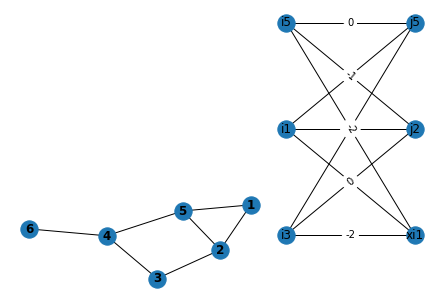

!!! mappings 1 ---> 3 !!!
edge weights
edge: ('i2', 'j2') -- weight: 0
edge: ('i2', 'j4') -- weight: 0
edge: ('i5', 'j2') -- weight: 0
edge: ('i5', 'j4') -- weight: 0


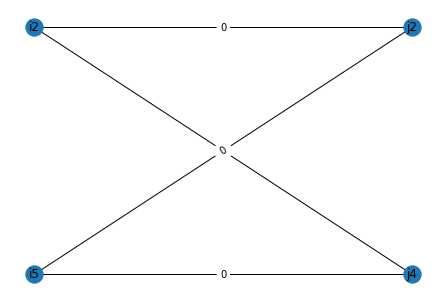

!!! mappings 1 ---> 4 !!!
edge weights
edge: ('i3', 'j2') -- weight: -1
edge: ('i3', 'j5') -- weight: -1
edge: ('i3', 'xi1') -- weight: -2
edge: ('i5', 'j2') -- weight: 0
edge: ('i5', 'j5') -- weight: 0
edge: ('i5', 'xi1') -- weight: -2
edge: ('i6', 'j2') -- weight: -2
edge: ('i6', 'j5') -- weight: -2
edge: ('i6', 'xi1') -- weight: -2


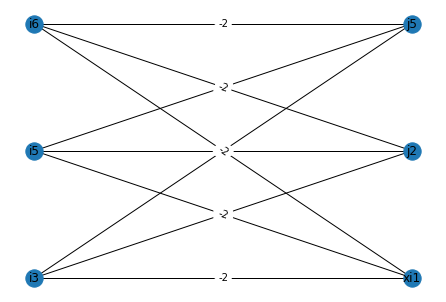

!!! mappings 1 ---> 5 !!!
edge weights
edge: ('i1', 'j2') -- weight: -2
edge: ('i1', 'j5') -- weight: 0
edge: ('i1', 'xi1') -- weight: -2
edge: ('i2', 'j2') -- weight: 0
edge: ('i2', 'j5') -- weight: -1
edge: ('i2', 'xi1') -- weight: -2
edge: ('i4', 'j2') -- weight: 0
edge: ('i4', 'j5') -- weight: -1
edge: ('i4', 'xi1') -- weight: -2


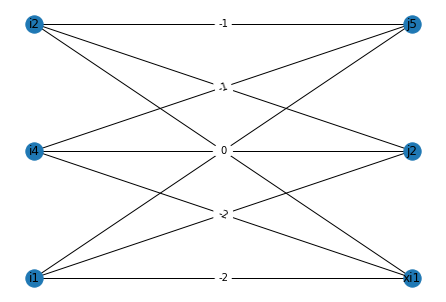

!!! mappings 1 ---> 6 !!!
edge weights
edge: ('i2', 'j4') -- weight: 0
edge: ('i2', 'xi1') -- weight: -2
edge: ('i5', 'j4') -- weight: 0
edge: ('i5', 'xi1') -- weight: -2


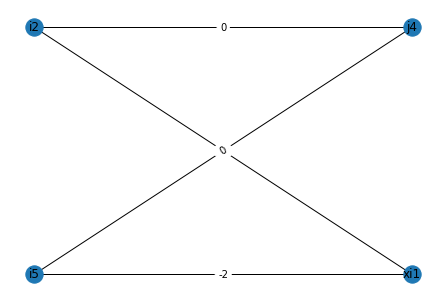

!!! mappings 2 ---> 3 !!!
edge weights
edge: ('i1', 'j2') -- weight: 0
edge: ('i1', 'j4') -- weight: -1
edge: ('i1', 'xi1') -- weight: -2
edge: ('i3', 'j2') -- weight: 0
edge: ('i3', 'j4') -- weight: -2
edge: ('i3', 'xi1') -- weight: -2
edge: ('i5', 'j2') -- weight: -1
edge: ('i5', 'j4') -- weight: 0
edge: ('i5', 'xi1') -- weight: -2


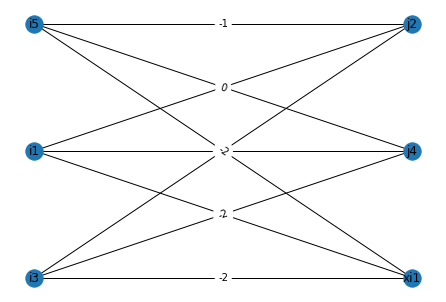

!!! mappings 2 ---> 4 !!!
edge weights
edge: ('i1', 'j3') -- weight: 0
edge: ('i1', 'j5') -- weight: -1
edge: ('i1', 'j6') -- weight: -1
edge: ('i3', 'j3') -- weight: 0
edge: ('i3', 'j5') -- weight: -1
edge: ('i3', 'j6') -- weight: -2
edge: ('i5', 'j3') -- weight: -1
edge: ('i5', 'j5') -- weight: 0
edge: ('i5', 'j6') -- weight: -2


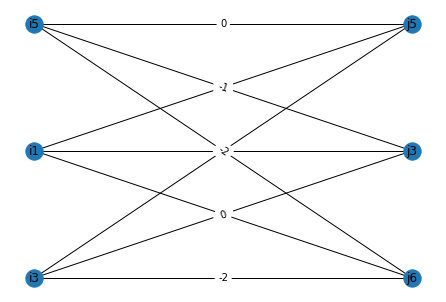

!!! mappings 2 ---> 5 !!!
edge weights
edge: ('i1', 'j1') -- weight: 0
edge: ('i1', 'j2') -- weight: 0
edge: ('i1', 'j4') -- weight: -1
edge: ('i3', 'j1') -- weight: 0
edge: ('i3', 'j2') -- weight: 0
edge: ('i3', 'j4') -- weight: -1
edge: ('i5', 'j1') -- weight: 0
edge: ('i5', 'j2') -- weight: 0
edge: ('i5', 'j4') -- weight: -1


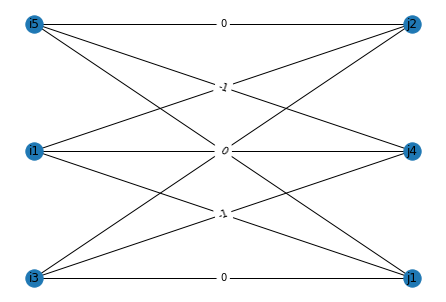

!!! mappings 2 ---> 6 !!!
edge weights
edge: ('i1', 'j4') -- weight: -1
edge: ('i1', 'xi1') -- weight: -2
edge: ('i1', 'xi2') -- weight: -2
edge: ('i3', 'j4') -- weight: -1
edge: ('i3', 'xi1') -- weight: -2
edge: ('i3', 'xi2') -- weight: -2
edge: ('i5', 'j4') -- weight: 0
edge: ('i5', 'xi1') -- weight: -2
edge: ('i5', 'xi2') -- weight: -2


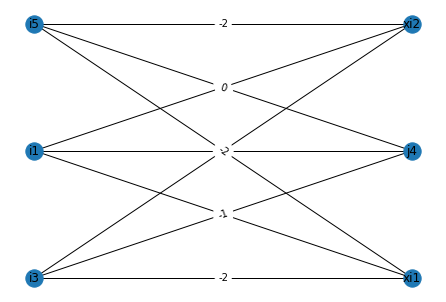

!!! mappings 3 ---> 4 !!!
edge weights
edge: ('i3', 'j2') -- weight: -2
edge: ('i3', 'j4') -- weight: 0
edge: ('i3', 'xi1') -- weight: -2
edge: ('i5', 'j2') -- weight: 0
edge: ('i5', 'j4') -- weight: -1
edge: ('i5', 'xi1') -- weight: -2
edge: ('i6', 'j2') -- weight: -2
edge: ('i6', 'j4') -- weight: -1
edge: ('i6', 'xi1') -- weight: -2


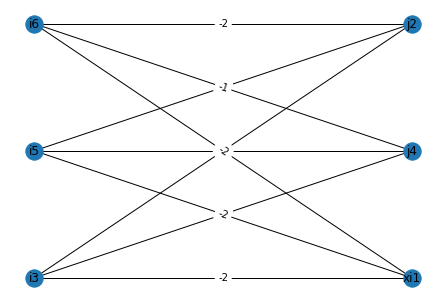

!!! mappings 3 ---> 5 !!!
edge weights
edge: ('i1', 'j2') -- weight: -1
edge: ('i1', 'j4') -- weight: -2
edge: ('i1', 'xi1') -- weight: -2
edge: ('i2', 'j2') -- weight: 0
edge: ('i2', 'j4') -- weight: 0
edge: ('i2', 'xi1') -- weight: -2
edge: ('i4', 'j2') -- weight: 0
edge: ('i4', 'j4') -- weight: 0
edge: ('i4', 'xi1') -- weight: -2


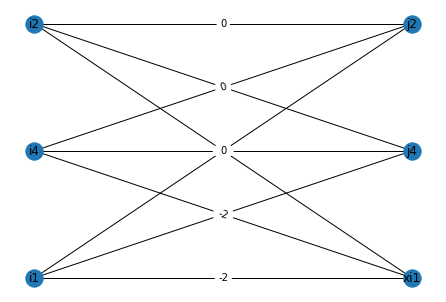

!!! mappings 3 ---> 6 !!!
edge weights
edge: ('i2', 'j4') -- weight: 0
edge: ('i2', 'xi1') -- weight: -2
edge: ('i4', 'j4') -- weight: 0
edge: ('i4', 'xi1') -- weight: -2


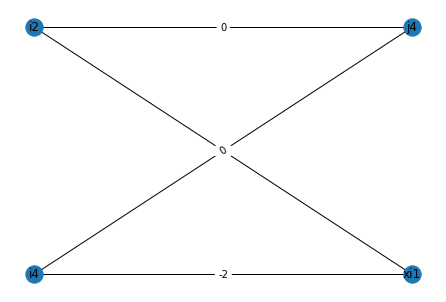

!!! mappings 4 ---> 5 !!!
edge weights
edge: ('i3', 'j1') -- weight: 0
edge: ('i3', 'j2') -- weight: -1
edge: ('i3', 'j4') -- weight: 0
edge: ('i5', 'j1') -- weight: 0
edge: ('i5', 'j2') -- weight: -1
edge: ('i5', 'j4') -- weight: 0
edge: ('i6', 'j1') -- weight: -1
edge: ('i6', 'j2') -- weight: -2
edge: ('i6', 'j4') -- weight: -1


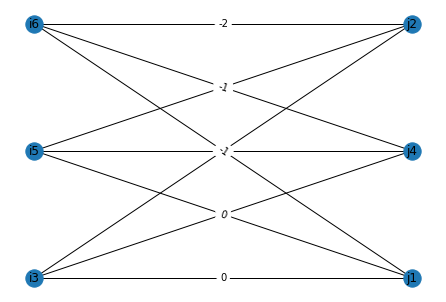

!!! mappings 4 ---> 6 !!!
edge weights
edge: ('i3', 'j4') -- weight: 0
edge: ('i3', 'xi1') -- weight: -2
edge: ('i3', 'xi2') -- weight: -2
edge: ('i5', 'j4') -- weight: -1
edge: ('i5', 'xi1') -- weight: -2
edge: ('i5', 'xi2') -- weight: -2
edge: ('i6', 'j4') -- weight: 0
edge: ('i6', 'xi1') -- weight: -2
edge: ('i6', 'xi2') -- weight: -2


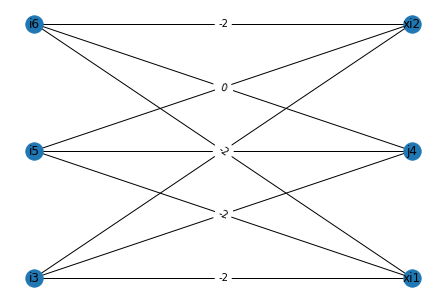

!!! mappings 5 ---> 6 !!!
edge weights
edge: ('i1', 'j4') -- weight: -2
edge: ('i1', 'xi1') -- weight: -2
edge: ('i1', 'xi2') -- weight: -2
edge: ('i2', 'j4') -- weight: 0
edge: ('i2', 'xi1') -- weight: -2
edge: ('i2', 'xi2') -- weight: -2
edge: ('i4', 'j4') -- weight: 0
edge: ('i4', 'xi1') -- weight: -2
edge: ('i4', 'xi2') -- weight: -2


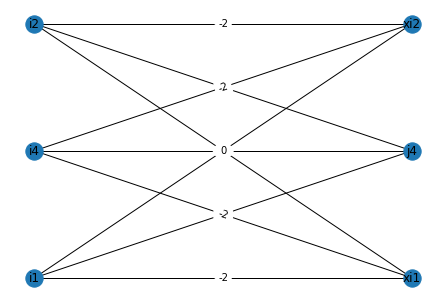

After initialization:
(1, 2) [(3, 2)]
(1, 3) []
(1, 5) [(5, 4)]
(1, 6) [(1, 2)]
(2, 3) [(1, 2)]
(2, 4) []
(2, 5) []
(3, 4) [(4, 6)]
(3, 5) [(1, 5)]
(3, 6) [(3, 2)]
(4, 5) []
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
1

15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
1

15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
1

15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
1

15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
1

KeyboardInterrupt: 

In [23]:
#
#
nx.draw(G_A,with_labels=True,font_weight='bold')
#
# variables
#
k_A = 1
jim_elim_while(G_A,Ef_A,k_A)

# while t.e. weights 
#Initiation:
#for all pairs i and j, solve matching problem on ij. 
#If matching score is <= 2* budget
#    \overline{P}_{ij} = score
#Else
#   \overline{P}_{ij} = \infty
#   for every (i','j) already tested with i,j neighbors of at least one of i' and j', \overline{P}_{ij} += 4


#
# initialization






#  - - - - - Comparison of Edges Killed - - - - - 

# Refine By Matching Driver

In [ ]:
nx.draw(G_A, with_labels=True, font_weight='bold')
plt.show()
#initialize
k_A = 1

b4dde = len(P_A.edges())
b4ddeMat = nx.adjacency_matrix(P_A).todense()
P_A = DegreeDiffElim(G_A,P_A,k_A)
afterdde = len(P_A.edges())
afterddeMat = nx.adjacency_matrix(P_A).todense()
print("Refine by Matching output below")
pm = RefineByMatching(G_A,P_A,Ef_A,k_A)
print("Refine by Matching output above")
#print(f" unproven mappings before DegreeDiffElim: {b4dde} \n")
#print(np.matrix(b4ddeMat))
#print(f"\n unproven mappings after DegreeDiffElim, before RBM: {afterdde} \n")
#print(np.matrix(afterddeMat))
#print(f"\n unproven mappings after RBM:  {len(P_A.edges())}\n")
#print(np.matrix(nx.adjacency_matrix(P_A).todense()))
for _k in pm.keys():
    print(f" mapping {_k} possible when {pm[_k]} is deleted")


#
# draw bipartite graph
#
#l,r = bipartite.sets(cm)
#pos = dict()
#pos.update( (nn, (1, ii+ len(l)/2)) for ii, nn in enumerate(l) ) # put nodes from X at x=1
#pos.update( (nn, (2, n*ii)) for ii, nn in enumerate(r) ) # put nodes from Y at x=2
#nx.draw(cm, pos=pos,with_labels=True)

#edge weights
#labels = nx.get_edge_attributes(cm, "weight")
#nx.draw_networkx_edge_labels(cm, pos=pos, edge_labels=labels)
plt.show()